In [1]:
import numpy as np
from empiricaldist import Pmf
from scipy.stats import binom
import matplotlib.pyplot as plt
import pandas as pd

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

### Exercise: 

When you generate a D&D character, instead of rolling dice, you can use the “standard array” of attributes, which is 15, 14, 13, 12, 10, and 8. Do you think you are better off using the standard array or (literally) rolling the dice?

Compare the distribution of the values in the standard array to the distribution we computed for the best three out of four:

- Which distribution has higher mean? Use the mean method.

- Which distribution has higher standard deviation? Use the std method.

- The lowest value in the standard array is 8. For each attribute, what is the probability of getting a value less than 8? If you roll the dice six times, what’s the probability that at least one of your attributes is less than 8?

- The highest value in the standard array is 15. For each attribute, what is the probability of getting a value greater than 15? If you roll the dice six times, what’s the probability that at least one of your attributes is greater than 15?

In [2]:
from empiricaldist import Cdf, Pmf

# building cdf of standard
standard = [15,14,13,12,10,8]
cdf_standard = Cdf.from_seq(standard)

In [3]:
# doing the roll 4 & take max of 3 simulation
n = 10000
a = np.random.randint(1, 7, size=(n, 4)) # build an n x 4 
a.sort(axis=1)
t = a[:, 1:].sum(axis=1)
pmf_best3 = Pmf.from_seq(t)

In [4]:
# - Which distribution has higher mean? Use the mean method.
print(cdf_standard.mean())
print(pmf_best3.mean()) # greater

12.0
12.253400000000001


In [5]:
# - Which distribution has higher std? Use the std method.
print(cdf_standard.std())
print(pmf_best3.std()) # greater

2.3804761428476167
2.870677348640909


In [6]:
# The lowest value in the standard array is 8. 
# For each attribute, what is the probability of getting a value less than 8? 
print(pmf_best3.lt_dist(8))

0.058800000000000005


In [7]:
# If you roll the dice six times, what’s the probability that at least 
# one of your attributes is less than 8?

# solve for complement (all greater than or equal to 8)
l_ge_8 = 1 - (pmf_best3.lt_dist(8))

# solve for likelihood that all 6 are greater than or equal to 8:
all_6_exceed_8 = (l_ge_8) ** 6

# subtract from 1, which means 1 or more are below 8
print(1 - all_6_exceed_8)

0.3048292170727033


In [8]:
# The highest value in the standard array is 15. 
# For each attribute, what is the probability of getting a value greater than 15? 
# If you roll the dice six times, what’s the probability that at least one 
# of your attributes is greater than 15?
print(pmf_best3.gt_dist(15))
l_gt_15 = pmf_best3.gt_dist(15)

# solve for complement, meaning no attribute is greater than 15
all_6_under_15 = (1 - l_gt_15) ** 6

# solve for complement again: means 1 or more attributes exceed 15
print(1 - all_6_under_15)

0.133
0.5752683890595043


### Exercise: 

Suppose you are fighting three monsters:

- One is armed with a short sword that causes one 6-sided die of damage,

- One is armed with a battle axe that causes one 8-sided die of damage, and

- One is armed with a bastard sword that causes one 10-sided die of damage.

One of the monsters, chosen at random, attacks you and does 1 point of damage.

Which monster do you think it was? Compute the posterior probability that each monster was the attacker.

If the same monster attacks you again, what is the probability that you suffer 6 points of damage?

Hint: Compute a posterior distribution as we have done before and pass it as one of the arguments to make_mixture.

### Confusion With This Problem:

- I failed to update the prior based on information around "if the same monster attacks you again, what is the prob that you suffer 6 points"

- The basic logic: 
    - Initially all monsters are equally likely (1/3 each)
    - The `1 damage` makes our 6-roll monster most likely (`(1/3 * 1/6) / ((1/3 * 1/6) + (1/3 * 1/8) + (1/3 * 1/10)) = 0.425`)
    - The posterior we build is what we need to use for the next step since we still assume any monster might have hit us. 
       - the problem is a mixture as we want to know likelihood of 6 points of damage given all information, not for specific monsters. 
    - Thus we pass in our posterior as a prior, and utilize the same likelihoods as before
        - The mixture is simple: It multiplies the prior across all likelihoods, and then sums up at an event level (e.g. roll a 1 regardless of monster). 
        - The sum of this output df is 1

In [9]:
def make_die(sides):
    """Pmf that represents a die with the given number of sides.
    sides: int
    returns: Pmf
    """
    outcomes = np.arange(1, sides+1)
    die = Pmf(1/sides, outcomes)
    return die

In [10]:
# the different monsters
hypos = [6,8,10]

# prior is uniform
counts = [1,1,1]

# build a prior per monster
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
print("Prior:\n")
print(pmf_dice)
print("")

# build a die per monster based on number of sides in hypos
dice = [make_die(sides) for sides in hypos]

# replace NaN with 0s, and build likelihood of each roll
likelihood = pd.DataFrame(dice).fillna(0).transpose()
print("Likelihood:\n")
print(likelihood)
print("")

# likelihood of rolling a 1 (index 0) * prior
# This is generated for each hypothesis (monster)
posterior = likelihood.iloc[0].values * pmf_dice
posterior.normalize()
print("Posterior:\n")
print(posterior)
print("")

Prior:

6     0.333333
8     0.333333
10    0.333333
Name: , dtype: float64

Likelihood:

                        
1   0.166667  0.125  0.1
2   0.166667  0.125  0.1
3   0.166667  0.125  0.1
4   0.166667  0.125  0.1
5   0.166667  0.125  0.1
6   0.166667  0.125  0.1
7   0.000000  0.125  0.1
8   0.000000  0.125  0.1
9   0.000000  0.000  0.1
10  0.000000  0.000  0.1

Posterior:

6     0.425532
8     0.319149
10    0.255319
Name: , dtype: float64



0.13634751773049647


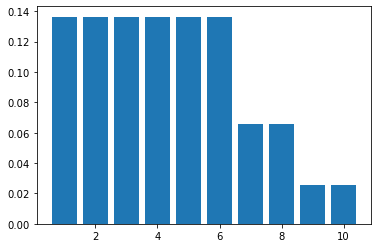

In [11]:
def make_mixture(pmf, pmf_seq):
    """
    Make a mixture of distributions.
    
    Basic computation:
    - Convert pmf seq to be a dataframe of probabilities per roll (evidence)
    - Multiply each by prior (numpy will broadcast the prior using "stretching" to cover all columns) 
    - Sum up at a row-level: this shows likelihood of a specific roll (evidence) occurring  
    
    """
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    
    # ensure total sum is around 1
    np.testing.assert_almost_equal(np.sum(total) , 1)
    
    return Pmf(total)

# Here's a sequence that represents the three dice
d6 = make_die(6)
d8 = make_die(8)
d10 = make_die(10)

dice = d6, d8, d10

# Posterior from earlier is passed as prior to sequence
# We use posterior as prior since we assume the same monster attacks us
# and want to find likelihood of 6 points of damage. 
mix3 = make_mixture(posterior, dice)
mix3.bar();

print(mix3[6])

### Exercise: 

Henri Poincaré was a French mathematician who taught at the Sorbonne around 1900. The following anecdote about him is probably fiction, but it makes an interesting probability problem.

Supposedly Poincaré suspected that his local bakery was selling loaves of bread that were lighter than the advertised weight of 1 kg, so every day for a year he bought a loaf of bread, brought it home and weighed it. At the end of the year, he plotted the distribution of his measurements and showed that it fit a normal distribution with mean 950 g and standard deviation 50 g. He brought this evidence to the bread police, who gave the baker a warning.

For the next year, Poincaré continued to weigh his bread every day. At the end of the year, he found that the average weight was 1000 g, just as it should be, but again he complained to the bread police, and this time they fined the baker.

Why? Because the shape of the new distribution was asymmetric. Unlike the normal distribution, it was skewed to the right, which is consistent with the hypothesis that the baker was still making 950 g loaves, but deliberately giving Poincaré the heavier ones.

To see whether this anecdote is plausible, let’s suppose that when the baker sees Poincaré coming, he hefts n loaves of bread and gives Poincaré the heaviest one. How many loaves would the baker have to heft to make the average of the maximum 1000 g?

To get you started, I’ll generate a year’s worth of data from a normal distribution with the given parameters.


### How I Solved This:

I deviated from the chapter slightly and ran a simple simulation for different sets of `n` until I found a mean (across 365 samples) that exceeded 1000.

In [12]:
# params for normal distr
mean = 950
std = 50

np.random.seed(17)
sample = np.random.normal(mean, std, size=365)

In [13]:
# if our n was "3" then we can sample for a single day this way
n = 3
day = np.random.choice(sample, n)
np.max(day)

977.800144305531

In [14]:
# random choice n times 365 times
# size = (m,n) where m is rows (days) and n is cols (loaves hefted)
year = np.random.choice(sample, size = (365, n))
print(year.shape)

# get max of each row
array_maxes = np.max(year, axis = 1)
print(array_maxes.shape)

# find mean
np.mean(array_maxes)

(365, 3)
(365,)


989.2224999632252

In [15]:
# run over more ranges:
for n in range(1,10):
    print(f"Running simulation for hefting {n} loaves")
    year = np.random.choice(sample, size = (365, n))
    array_maxes = np.max(year, axis = 1)
    print(f"Mean: {np.mean(array_maxes):.2f}")

Running simulation for hefting 1 loaves
Mean: 951.44
Running simulation for hefting 2 loaves
Mean: 979.73
Running simulation for hefting 3 loaves
Mean: 993.62
Running simulation for hefting 4 loaves
Mean: 997.68
Running simulation for hefting 5 loaves
Mean: 1008.66
Running simulation for hefting 6 loaves
Mean: 1015.60
Running simulation for hefting 7 loaves
Mean: 1016.93
Running simulation for hefting 8 loaves
Mean: 1021.13
Running simulation for hefting 9 loaves
Mean: 1026.80


In [16]:
# run over more ranges:
nn = 1000 # samples
for n in range(1,10):
    print(f"Running simulation for hefting {n} loaves")
    year_mean = []
    for _ in range(nn):
        year = np.random.choice(sample, size = (365, n))
        array_maxes = np.max(year, axis = 1)
        year_mean.append(np.mean(array_maxes))
    print(f"Mean (of means): {np.mean(year_mean):.2f}")

Running simulation for hefting 1 loaves
Mean (of means): 950.02
Running simulation for hefting 2 loaves
Mean (of means): 978.43
Running simulation for hefting 3 loaves
Mean (of means): 992.75
Running simulation for hefting 4 loaves
Mean (of means): 1002.08
Running simulation for hefting 5 loaves
Mean (of means): 1008.87
Running simulation for hefting 6 loaves
Mean (of means): 1014.25
Running simulation for hefting 7 loaves
Mean (of means): 1018.56
Running simulation for hefting 8 loaves
Mean (of means): 1022.22
Running simulation for hefting 9 loaves
Mean (of means): 1025.41


### Author's Solution: Avoid Simulation, Use CDFs

- build out a normal distribution with mean / std params
- `Cdf(x)` is the sum of probabilities for quantities less than or equal to `x`. 
    - This means it is the probability that a random value is less than or equal to x. 
    - If we draw `n` times, then we can write this as `Cdf(x)**n` to indicate the probability that all `n` are `<=` to `x`

4 1002.0372868686195
4 1001.1812417447794


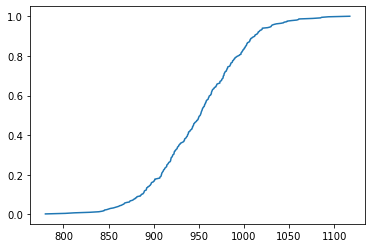

In [17]:
mean = 950
std = 50

np.random.seed(17)
sample = np.random.normal(mean, std, size=365)

# create cdf 
cdf = Cdf.from_seq(sample)
cdf.plot(label='one loaf');

# same logic as used above: 
# This is going to determine the distribution of max of n loaves
# This reflects the probability that all n <= X, where X is the weight
n = 4
cdf_max = cdf.max_dist(n)
print(n, cdf_max.mean())
print(n, cdf_max.median())

### Trying to Calculate the Mean:

In [19]:
# Same as what was done in the chapter
new_df = pd.concat([pd.Series(cdf.index.values), pd.Series(cdf.values)], axis = 1)
new_df.columns = ['value', 'prob']

# Calculate the probability that all n are <= X
out = new_df.prob ** n
new_df['max_prob'] = out


In [20]:
# This would be our median....struggling to actually back into mean
# Need to get values * prob?
new_df[np.round(new_df.max_prob,2) <= 0.5].tail(1)

,value,prob,max_prob
306,1001.181242,0.841096,0.500475


In [29]:
# unable to figure out how to pass in the qs and ps values 
# Seems like this should work for Cdf? 
Cdf(new_df.max_prob, index = new_df.value)

,probs
value,
780.003461,NaN
801.993869,NaN
812.040446,NaN
829.338382,NaN
839.193790,NaN
...,...
1076.262737,NaN
1084.871746,NaN
1086.039779,NaN


In [46]:
# Ah, here we go!
# Ideally I would be able to build a Cdf and convert to Pmf with
# my own ps and qs. But couldn't figure it out. So handling Pmf
# calculation by using differences between rows. 


# First, calculate the diff of each prob from Cdf
# 0th index is just its value - 0 since it is start
# 1st index - 0th index, etc.....
ps = new_df.max_prob - np.concatenate(([0], new_df.max_prob[:-1]))

# Next, we just get our "qs"
qs = new_df.value

# And mean is just the expected value, prob * val
np.sum(ps * qs)

1002.0372868686195

### 

Just noticed the method `make_pmf` from `Cdf` object is basically doing the same.....but much cleaner!

https://github.com/AllenDowney/empiricaldist/blob/master/empiricaldist/empiricaldist.py#L902-L916

np.diff = 
`Calculate the n-th discrete difference along the given axis.`

the prepend is how I handled the 0 above for the 0th index.

In [48]:
np.sum(np.diff(new_df.max_prob, prepend = 0) * qs)

1002.0372868686195